In [2]:
import math
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torch import Tensor
from matplotlib import cm
from torchvision.transforms.functional import to_pil_image
import os  

In [24]:
def process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT):  
    """  
    处理图片并计算特征和梯度的加权值donations_values  

    Args:  
        img_path (str): 输入图片的路径  
        model_weights: 模型的预训练权重，默认为ResNet50的默认权重  

    Returns:  
        tensor: shape (num_classes,) 的 tensor，表示各个类别的donations_values  
    """  
    # 定义预处理步骤  
    test_transform = transforms.Compose([  
        transforms.Resize(512),  
        transforms.ToTensor(),  
        transforms.Normalize(  
            mean=[0.485, 0.456, 0.406],  
            std=[0.229, 0.224, 0.225]  
        )  
    ])  

    # 获取设备  
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

    # 初始化模型  
    model = resnet50(weights=model_weights).eval().to(device)  

    # print(f"try to open image, path：{img_path}")  
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  
        print(f"跳过非图片文件：{img_path}")  
        return None  

    # 加载图片  
    img_pil = Image.open(img_path)  

    # 预处理图片  
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)  

    # 定义前向hook  
    def forward_hook(module, inp, outp):  
        feature_map.append(outp)  

    # 定义反向hook  
    def backward_hook(module, inp, outp):  
        grad.append(outp)  

    # 初始化容器  
    feature_map = []  
    grad = []  

    # 注册hook  
    hook_layer = model.layer4[-1]  
    hook_handle = hook_layer.register_forward_hook(forward_hook)  
    grad_hook_handle = hook_layer.register_full_backward_hook(backward_hook)  

    try:  
        # 前向传播  
      
        out = model(input_tensor)  
        cls_idx = torch.argmax(out).item()  
        # 计算预测类别分数  
        score = out[:, cls_idx].sum()  

        # 反向传播  
        model.zero_grad()  
        score.backward(retain_graph=False)  # 减少内存占用  

        # 获取特征和梯度  
        weights = grad[0][0].squeeze(0).mean(dim=(1, 2))  #GAP(a)
        mean_values= feature_map[0].squeeze(0).mean(dim=(1, 2))  

        # 计算加权后的值  
        # donations_values = mean_values * weights  
        donations_values = mean_values

        return donations_values.detach().cpu()  

    except Exception as e:  
        print(f"处理过程中出现错误：{e}")  
        return None  

    finally:  
        # 删除hook并清理数据  
        hook_handle.remove()  
        grad_hook_handle.remove()  
        feature_map.clear()  
        grad.clear()  

        # 删除GPU上的张量并释放内存  
        if input_tensor.is_cuda:  
            del input_tensor  
            torch.cuda.empty_cache()  

        if 'out' in locals():  
            del out  
        if 'score' in locals():  
            del score

In [1]:
# img_path="dataset/波斯猫/1.jpg"
# donations_values=process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT)
# print(donations_values)
# # donations_values.size()

In [4]:
import numpy as np  

# 配置PyTorch的内存分配参数，减少内存碎片  
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'  

def process_batch_images(class_path, batch_size=8, device=None):  
    """  
    批量处理一个类别下的所有图片，并返回每张图片的donations_values  

    Args:  
        class_path (str): 类别图片的路径  
        batch_size (int): 批次大小，缺省值为8  
        device (str or torch.device, optional): 设备类型（"cpu" 或 "cuda"），缺省值为 None，会自动检测  

    Returns:  
        list: 包含每张图片的donations_values 的列表  
    """  
    if device is None:  
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
    print()
    print("using device:"+str(device))
    print("analyse class:"+str(class_path))
    donations_values_list = []  

    # 获取图片文件路径列表  
    img_paths = [os.path.join(class_path, f) for f in os.listdir(class_path)  
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]  

    # 计算总批次数  
    total_batches = len(img_paths) // batch_size  
    if len(img_paths) % batch_size != 0:  
        total_batches += 1  

    succeed_img = 0
    # 分批次处理图片  
    for batch_idx in range(total_batches):  
        start = batch_idx * batch_size  
        end = min((batch_idx + 1) * batch_size, len(img_paths))  
        batch_paths = img_paths[start:end]  

        batch_features = []  

        # 逐张处理图片以减少内存占用  
        for img_path in batch_paths:  
            try:  
                # 使用process_image_withhooks处理图片  
                donations_value = process_image_withhooks(img_path)  

                if donations_value is not None:  
                    # 添加到批次结果  
                    # print("succeed to process image:"+img_path)
                    succeed_img += 1
                    batch_features.append(donations_value)  

            except Exception as e:  
                print(f"处理 {img_path} 时发生错误：{str(e)}")  
                continue  

        # 如果批次中没有有效的特征，跳过  
        if not batch_features:  
            continue  

        # 将批次的特征拼接到结果列表  
        donations_values_list.extend(batch_features)  

        # 释放当前批次的内存  
        batch_features.clear()  

    print(f"all_imgs : {succeed_img}")
    return donations_values_list


In [5]:
class_path1="dataset/n02105505/" #匈牙利牧羊犬
class_path2="dataset/n02101006/" #戈登雪达犬
class_path3="dataset/n01910747/" #水母
donations_values_list1 = process_batch_images(class_path1)
donations_values_list2 = process_batch_images(class_path2)
donations_values_list3 = process_batch_images(class_path3)



using device:cuda
analyse class:dataset/n02105505/


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


all_imgs : 100

using device:cuda
analyse class:dataset/n02101006/
all_imgs : 100

using device:cuda
analyse class:dataset/n01910747/
all_imgs : 55


In [10]:
from sklearn.metrics.pairwise import cosine_similarity  
import numpy as np  

def calculate_intra_class_similarity(donations_values_list):  
    """  
    计算类内相似度  

    Args:  
        donations_values_list (list): 包含一个类别中所有图片的donations_values的列表  

    Returns:  
        float: 类内相似度的平均值  
    """  
    if len(donations_values_list) < 2:  
        return 0.0  # 如果类别中图片少于2张，无法计算相似度  

    # 将tensor列表转换为numpy数组  
    donations_array = np.stack([tensor.numpy() for tensor in donations_values_list])  

    # 计算余弦相似度矩阵  
    similarity_matrix = cosine_similarity(donations_array)  

    # 取上三角部分（忽略对角线）  
    upper_triangle = np.triu(similarity_matrix, k=1)  

    # 计算平均值  
    num_pairs = len(donations_values_list) * (len(donations_values_list) - 1) // 2  
    return np.sum(upper_triangle) / num_pairs 

In [11]:
def calculate_inter_class_similarity(class1_values, class2_values):  
    """  
    计算类间相似度  

    Args:  
        class1_values (list): 类别1的donations_values列表  
        class2_values (list): 类别2的donations_values列表  

    Returns:  
        float: 类间相似度的平均值  
    """  
    if len(class1_values) == 0 or len(class2_values) == 0:  
        return 0.0  # 如果某一类别没有数据，无法计算相似度  

    # 将tensor列表转换为numpy数组  
    class1_array = np.stack([tensor.numpy() for tensor in class1_values])  
    class2_array = np.stack([tensor.numpy() for tensor in class2_values])  

    # 计算余弦相似度矩阵  
    similarity_matrix = cosine_similarity(class1_array, class2_array)  

    # 返回平均值  
    return np.mean(similarity_matrix)

In [12]:
# def batch_process_and_analyze(dataset_path,class1,class2):  
#     """  
#     批量处理图片并计算类内和类间相似度  

#     Args:  
#         dataset_path (str): 数据集路径，包含两个类别文件夹class1和class2  

#     Returns:  
#         tuple: (intra_class_similarity_class1, intra_class_similarity_class2, inter_class_similarity)  
#     """  
#     class1_path = os.path.join(dataset_path, class1)  
#     class2_path = os.path.join(dataset_path, class2)  

#     # 处理两个类别的图片  
#     class1_values = process_batch_images(class1_path)  
#     class2_values = process_batch_images(class2_path)  

#     # 计算类内相似度  
#     intra_class_similarity_class1 = calculate_intra_class_similarity(class1_values)  
#     intra_class_similarity_class2 = calculate_intra_class_similarity(class2_values)  

#     # 计算类间相似度  
#     inter_class_similarity = calculate_inter_class_similarity(class1_values, class2_values)  

#     return intra_class_similarity_class1, intra_class_similarity_class2, inter_class_similarity

In [16]:
import os  
from prettytable import PrettyTable  

def batch_process_and_analyze(dataset_path, class1, class2):  
    """  
    批量处理图片并计算类内和类间相似度  

    Args:  
        dataset_path (str): 数据集路径，包含两个类别文件夹class1和class2  

    Returns:  
        tuple: (intra_class_similarity_class1, intra_class_similarity_class2, inter_class_similarity)  
    """  
    class1_path = os.path.join(dataset_path, class1)  
    class2_path = os.path.join(dataset_path, class2)  

    # 处理两个类别的图片  
    class1_values = process_batch_images(class1_path)  
    class2_values = process_batch_images(class2_path)  

    # 计算类内相似度  
    intra_class_similarity_class1 = calculate_intra_class_similarity(class1_values)  
    intra_class_similarity_class2 = calculate_intra_class_similarity(class2_values)  

    # 计算类间相似度  
    inter_class_similarity = calculate_inter_class_similarity(class1_values, class2_values)  

    return intra_class_similarity_class1, intra_class_similarity_class2, inter_class_similarity

In [25]:
dataset_path = "dataset/"  
intra_class1, intra_class2, inter_class = batch_process_and_analyze(dataset_path,"n01532829/","n01558993/")  
print()
print(f"Class1 类内相似度: {intra_class1}")  
print(f"Class2 类内相似度: {intra_class2}")  
print(f"Class1 和 Class2 类间相似度: {inter_class}") 


using device:cuda
analyse class:dataset/n01532829/
all_imgs : 100

using device:cuda
analyse class:dataset/n01558993/
all_imgs : 100

Class1 类内相似度: 0.44999008641098487
Class2 类内相似度: 0.4573083372790404
Class1 和 Class2 类间相似度: 0.3561665117740631


In [27]:
dataset_path = "dataset/"  
intra_class1, intra_class2, inter_class = batch_process_and_analyze(dataset_path,"n02105505/","n01910747/")  
print()
print(f"Class1 类内相似度: {intra_class1}")  
print(f"Class2 类内相似度: {intra_class2}")  
print(f"Class1 和 Class2 类间相似度: {inter_class}") 


using device:cuda
analyse class:dataset/n02105505/
all_imgs : 100

using device:cuda
analyse class:dataset/n01910747/
all_imgs : 55

Class1 类内相似度: 0.48397140348800505
Class2 类内相似度: 0.49512450349852694
Class1 和 Class2 类间相似度: 0.2049800008535385


In [26]:
dataset_path = "dataset/"  
intra_class1, intra_class2, inter_class = batch_process_and_analyze(dataset_path,"n02105505/","n02108089/")  
print()
print(f"Class1 类内相似度: {intra_class1}")  
print(f"Class2 类内相似度: {intra_class2}")  
print(f"Class1 和 Class2 类间相似度: {inter_class}") 


using device:cuda
analyse class:dataset/n02105505/
all_imgs : 100

using device:cuda
analyse class:dataset/n02108089/
all_imgs : 100

Class1 类内相似度: 0.48397140348800505
Class2 类内相似度: 0.47141256313131313
Class1 和 Class2 类间相似度: 0.3175468146800995


In [13]:
from sklearn.metrics.pairwise import cosine_similarity  
import numpy as np  

def analyze_intra_class_similarity(donations_values_list, top_n=20):  
    """  
    分析同一类别中所有图片两两之间的余弦相似度，并返回相似度最大的和最小的样本对。  

    Args:  
        donations_values_list (list): 包含一个类别中所有图片的donations_values的列表。  
        top_n (int, optional): 指定要返回的最大和最小的样本对数。默认为20。  

    Returns:  
        dict: 一个字典，包含：  
            - 'max_similarity': 相似度最大的top_n组样本对的相似度值和索引。  
            - 'min_similarity': 相似度最小的top_n组样本对的相似度值和索引。  

    Raises:  
        ValueError: 如果donations_values_list的长度小于2。  
    """  
    if len(donations_values_list) < 2:  
        raise ValueError("需要至少两个样本来计算相似度.")  

    # 将张量列表转换为numpy数组  
    donations_array = np.stack([tensor.numpy() for tensor in donations_values_list])  

    # 计算余弦相似度矩阵  
    similarity_matrix = cosine_similarity(donations_array)  

    # 提取上三角部分，忽略对角线  
    upper_triangle = np.triu(similarity_matrix, k=1)  

    # 展平上三角部分为1D数组，并获取索引  
    upper_triangle_flat = upper_triangle.flatten()  
    indices = np.triu_indices(len(upper_triangle), k=1)  

    # 创建一个数组，保存每个相似度值及其对应的两个样本索引  
    similarity_with_indices = list(zip(upper_triangle_flat, *indices))  

    # 将相似度值从大到小排序  
    similarity_with_indices.sort(key=lambda x: -x[0])  

    # 提取最大的top_n组  
    max_similarity = []  
    for i in range(top_n):  
        if i >= len(similarity_with_indices):  
            break  
        similarity, idx1, idx2 = similarity_with_indices[i]  
        max_similarity.append({  
            'similarity': similarity,  
            'sample1_idx': idx1,  
            'sample2_idx': idx2  
        })  

    # 将相似度值从小到大排序  
    similarity_with_indices.sort(key=lambda x: x[0])  

    # 提取最小的top_n组  
    min_similarity = []  
    for i in range(top_n):  
        if i >= len(similarity_with_indices):  
            break  
        similarity, idx1, idx2 = similarity_with_indices[i]  
        min_similarity.append({  
            'similarity': similarity,  
            'sample1_idx': idx1,  
            'sample2_idx': idx2  
        })  

    return {  
        'max_similarity': max_similarity,  
        'min_similarity': min_similarity  
    } 

In [16]:
import matplotlib.pyplot as plt  
import seaborn as sns  
import pandas as pd  

def visualize_similarity_results(donations_values_list, result, top_n=20):  
    """  
    可视化相似度最大的和最小的样本对。  

    Args:  
        donations_values_list (list): 包含一个类别中所有图片的donations_values的列表。  
        result (dict): analyze_intra_class_similarity函数返回的结果。  
        top_n (int, optional): 指定要可视化的最大和最小的样本对数。默认为20。  

    Returns:  
        None  
    """  
    # 初始化matplotlib的参数  
    plt.rcParams['figure.dpi'] = 120  
    plt.rcParams['font.size'] = 10  

    # 创建一个figure和两个子图  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  

    # 可视化最大相似度的Top-20  
    max_similarity = result['max_similarity']  
    max_sim_values = [pair['similarity'] for pair in max_similarity[:top_n]]  
    max_sim_indices = [f"({pair['sample1_idx']}, {pair['sample2_idx']})" for pair in max_similarity[:top_n]]  

    # 可视化最小相似度的Top-20  
    min_similarity = result['min_similarity']  
    min_sim_values = [pair['similarity'] for pair in min_similarity[:top_n]]  
    min_sim_indices = [f"({pair['sample1_idx']}, {pair['sample2_idx']})" for pair in min_similarity[:top_n]]  



        # 最大相似度图  
    ax1.bar(max_sim_indices, max_sim_values)  
    ax1.set_title('Top-{} Similarity Pairs'.format(top_n))  
    ax1.set_xlabel('Class Max')  
    ax1.set_ylabel('Cosine Similarity')  
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  

    # 最小相似度图  
    ax2.bar(min_sim_indices, min_sim_values)  
    ax2.set_title('Bottom-{} Similarity Pairs'.format(top_n))  
    ax2.set_xlabel('Class Min')  
    ax2.set_ylabel('Cosine Similarity')  
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor') 

    plt.tight_layout()  
    plt.show()  



In [17]:
def intra_category_similarity(donations_values_list):
    # 计算相似度分析结果  
    result = analyze_intra_class_similarity(donations_values_list)  
    # 可视化结果  
    visualize_similarity_results(donations_values_list, result, top_n=20) 

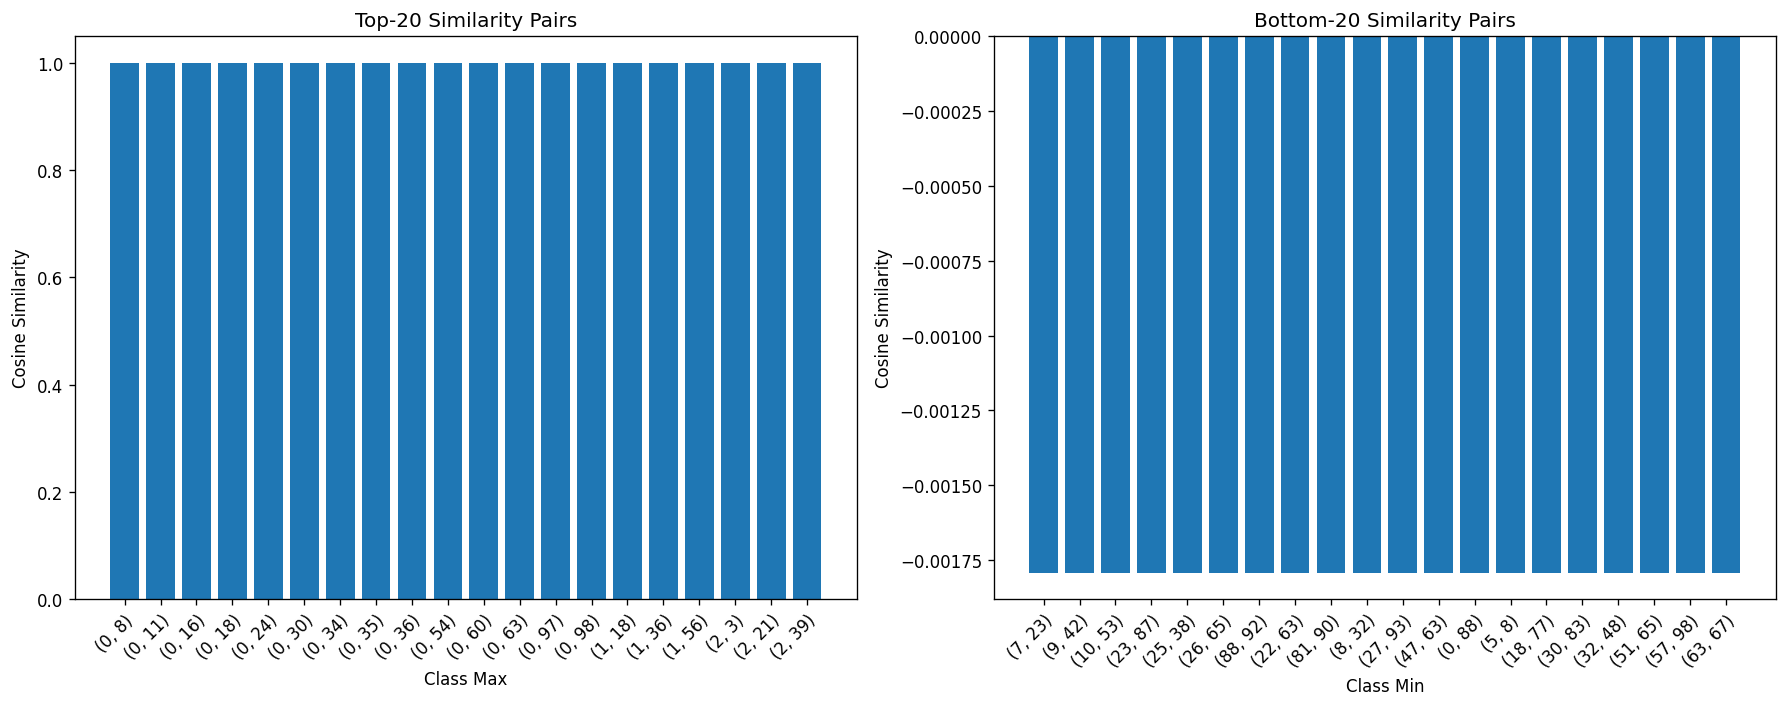

In [18]:
intra_category_similarity(donations_values_list1)

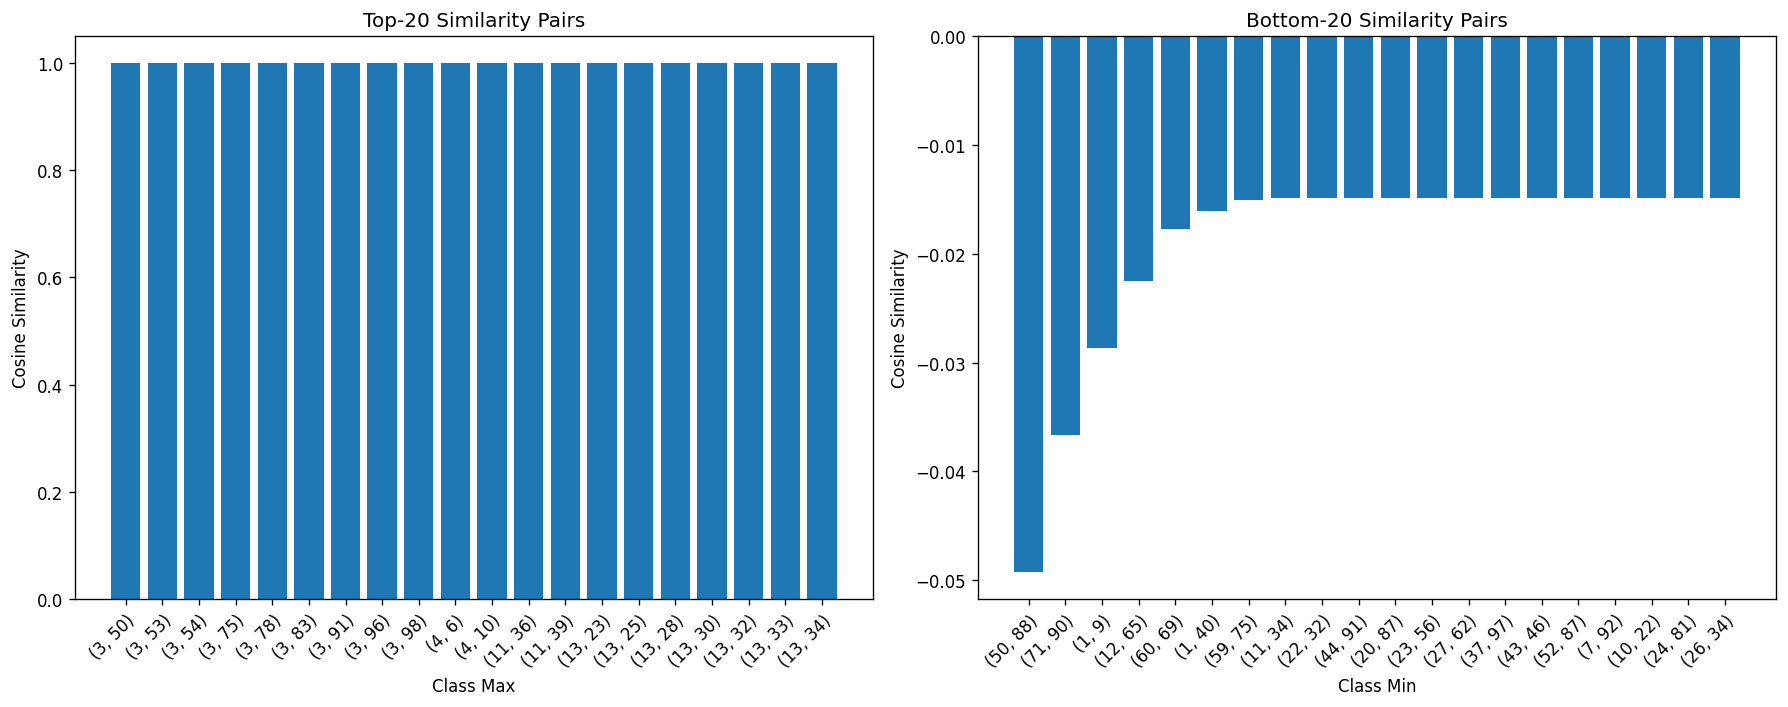

In [19]:
intra_category_similarity(donations_values_list2)

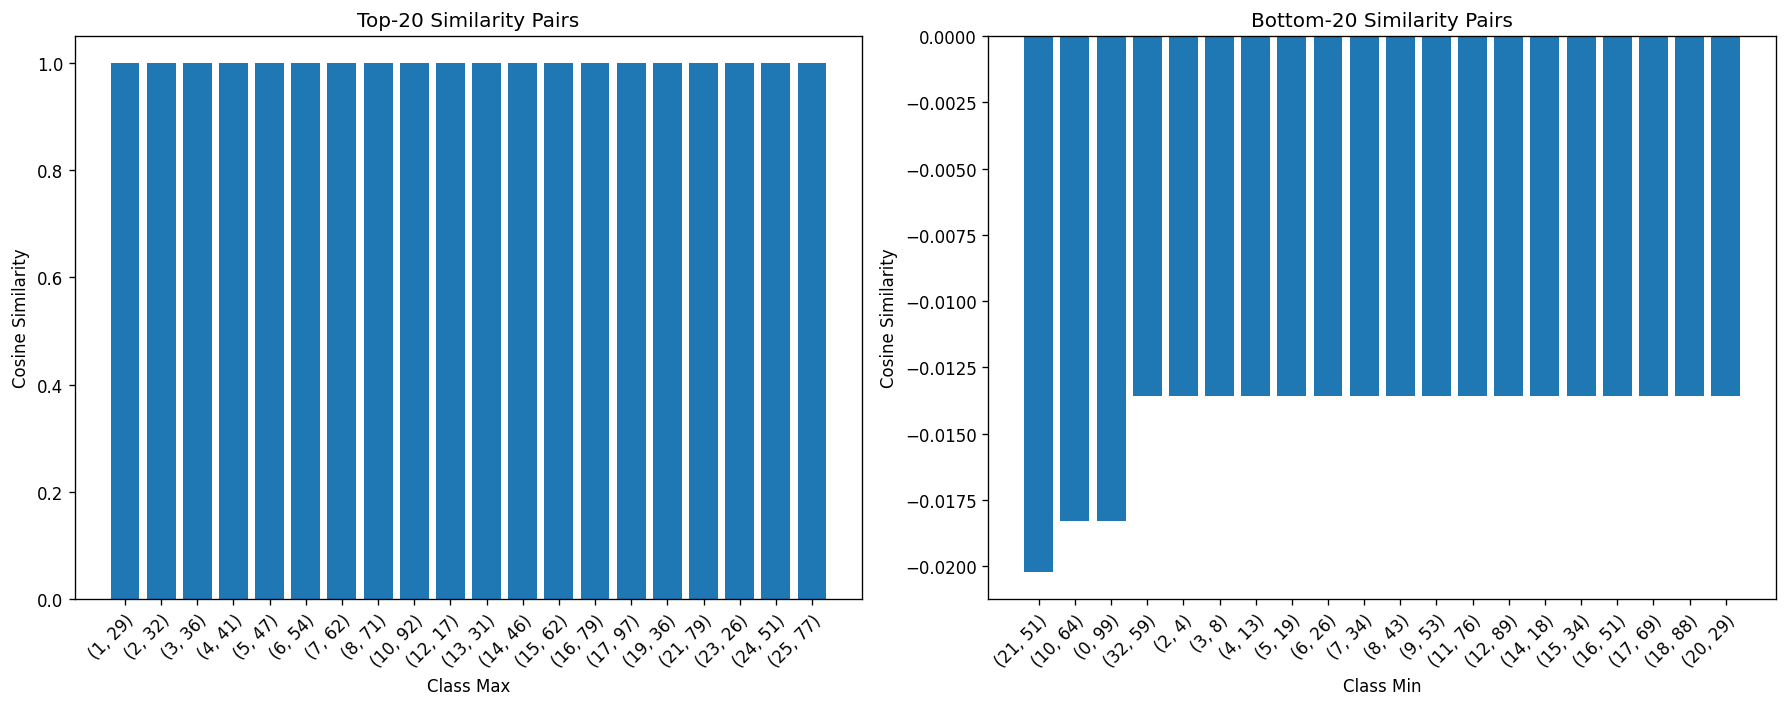

In [20]:
intra_category_similarity(donations_values_list3)

In [21]:
import numpy as np  
import matplotlib.pyplot as plt  

def cross_category_similarity(donations_values_list1, donations_values_list2, top_n=20):  
    """  
    分析两个类别间所有图片两两的余弦相似度，并返回相似度最大的和最小的样本对。  

    Parameters:  
        donations_values_list1 (list): 第一个类别的图片嵌入向量列表。  
        donations_values_list2 (list): 第二个类别的图片嵌入向量列表。  
        top_n (int, optional): 指定要返回和展示的样本对数。默认为20。  

    Returns:  
        dict: 包含max_similarity和min_similarity的结果。  
    """  

    # 初始化matplotlib的参数  
    plt.rcParams['figure.dpi'] = 120  
    plt.rcParams['font.size'] = 10  

    # 计算两类之间的余弦相似度  
    cross_similarity = []  
    for i, vec1 in enumerate(donations_values_list1):  
        for j, vec2 in enumerate(donations_values_list2):  
            # 计算点积  
            dot_product = np.dot(vec1, vec2)  
            # 计算模长  
            magnitude1 = np.linalg.norm(vec1)  
            magnitude2 = np.linalg.norm(vec2)  
            if magnitude1 == 0 or magnitude2 == 0:  
                similarity = 0.0  
            else:  
                similarity = dot_product / (magnitude1 * magnitude2)  
            cross_similarity.append({  
                'similarity': similarity,  
                'sample1_idx': i,  
                'sample2_idx': j  
            })  

    # 按相似度排序  
    cross_similarity.sort(key=lambda x: x['similarity'], reverse=True)  

    # 提取最大和最小的top_n  
    max_similarity = cross_similarity[:top_n]  
    min_similarity = cross_similarity[-top_n:]  

    # 为可视化准备数据  
    max_sim_values = [pair['similarity'] for pair in max_similarity]  
    max_sim_indices = [f"({pair['sample1_idx']}, {pair['sample2_idx']})" for pair in max_similarity]  

    min_sim_values = [pair['similarity'] for pair in min_similarity]  
    min_sim_indices = [f"({pair['sample1_idx']}, {pair['sample2_idx']})" for pair in min_similarity]  

    # 绘制柱状图  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  

    # 最大相似度图  
    ax1.bar(max_sim_indices, max_sim_values)  
    ax1.set_title('Top-{} Similarity Pairs'.format(top_n))  
    ax1.set_xlabel('Sample Pairs (Class1, Class2)')  
    ax1.set_ylabel('Cosine Similarity')  
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  

    # 最小相似度图  
    ax2.bar(min_sim_indices, min_sim_values)  
    ax2.set_title('Bottom-{} Similarity Pairs'.format(top_n))  
    ax2.set_xlabel('Sample Pairs (Class1, Class2)')  
    ax2.set_ylabel('Cosine Similarity')  
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  

    plt.tight_layout()  
    plt.show()  



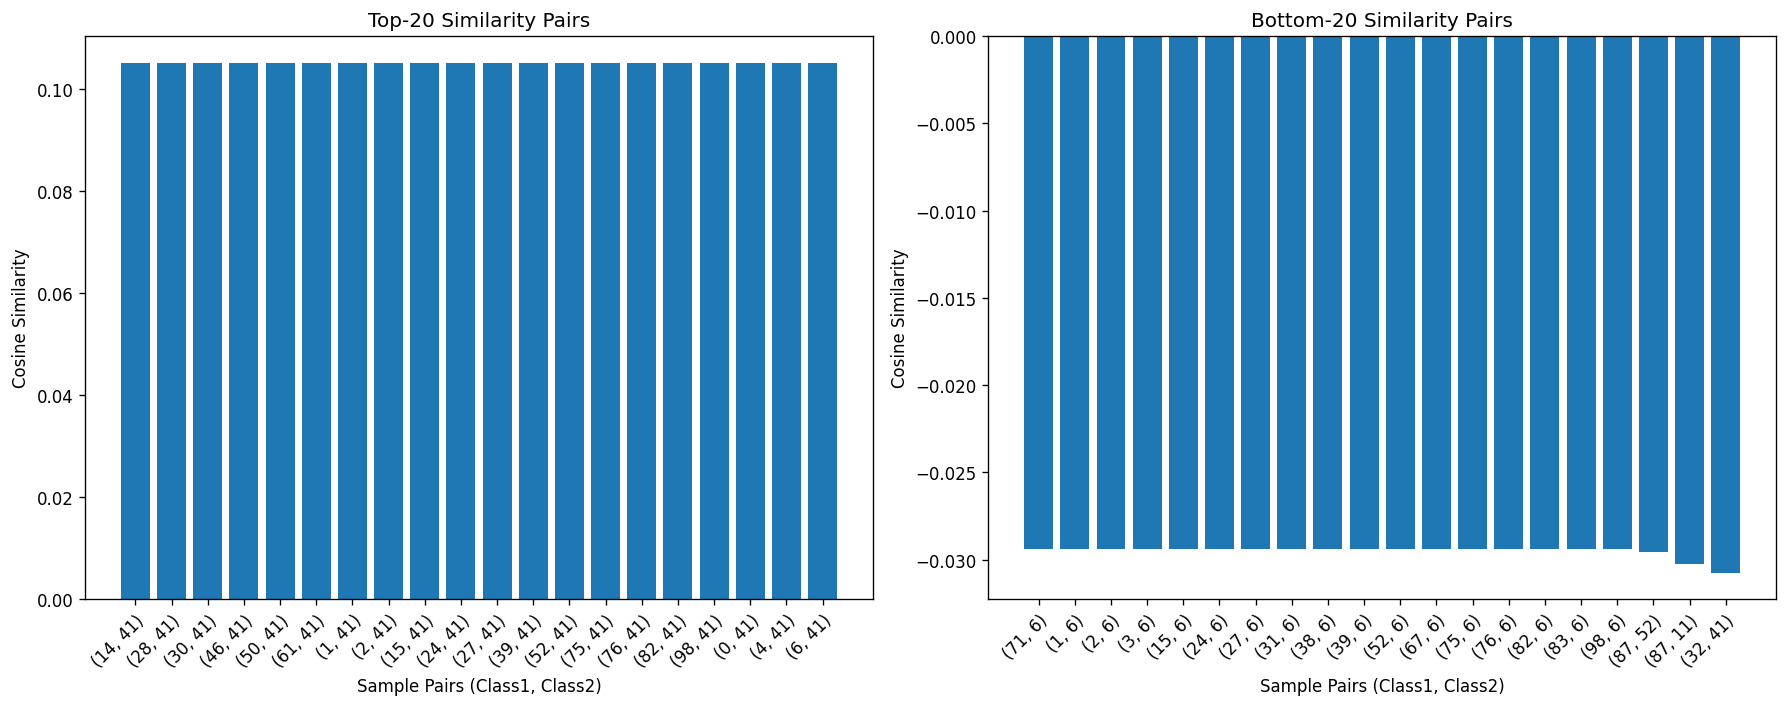

In [22]:
cross_category_similarity(donations_values_list1, donations_values_list2, top_n=20)

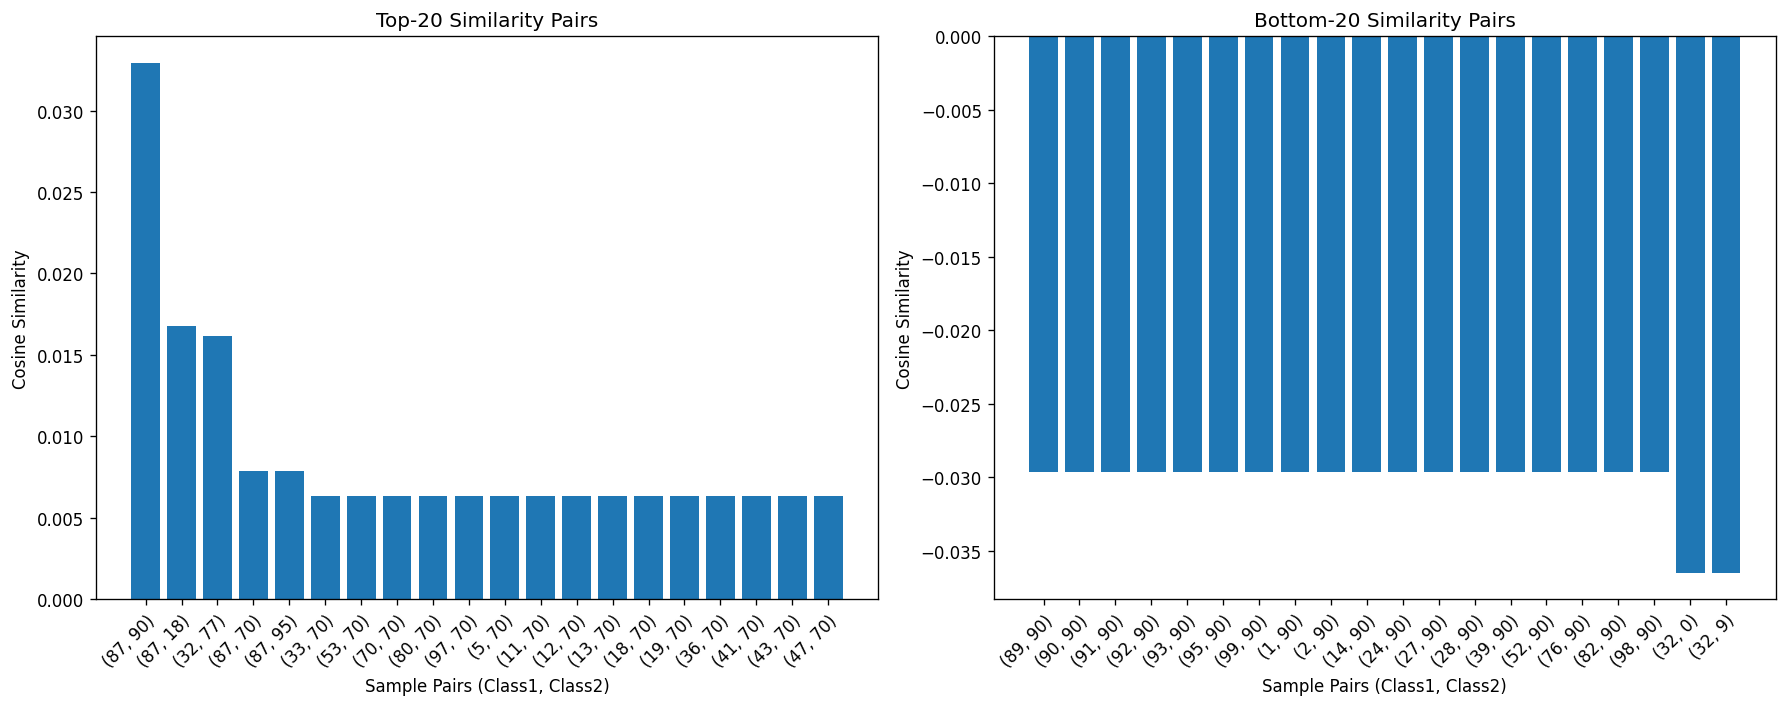

In [23]:
cross_category_similarity(donations_values_list1, donations_values_list3, top_n=20)

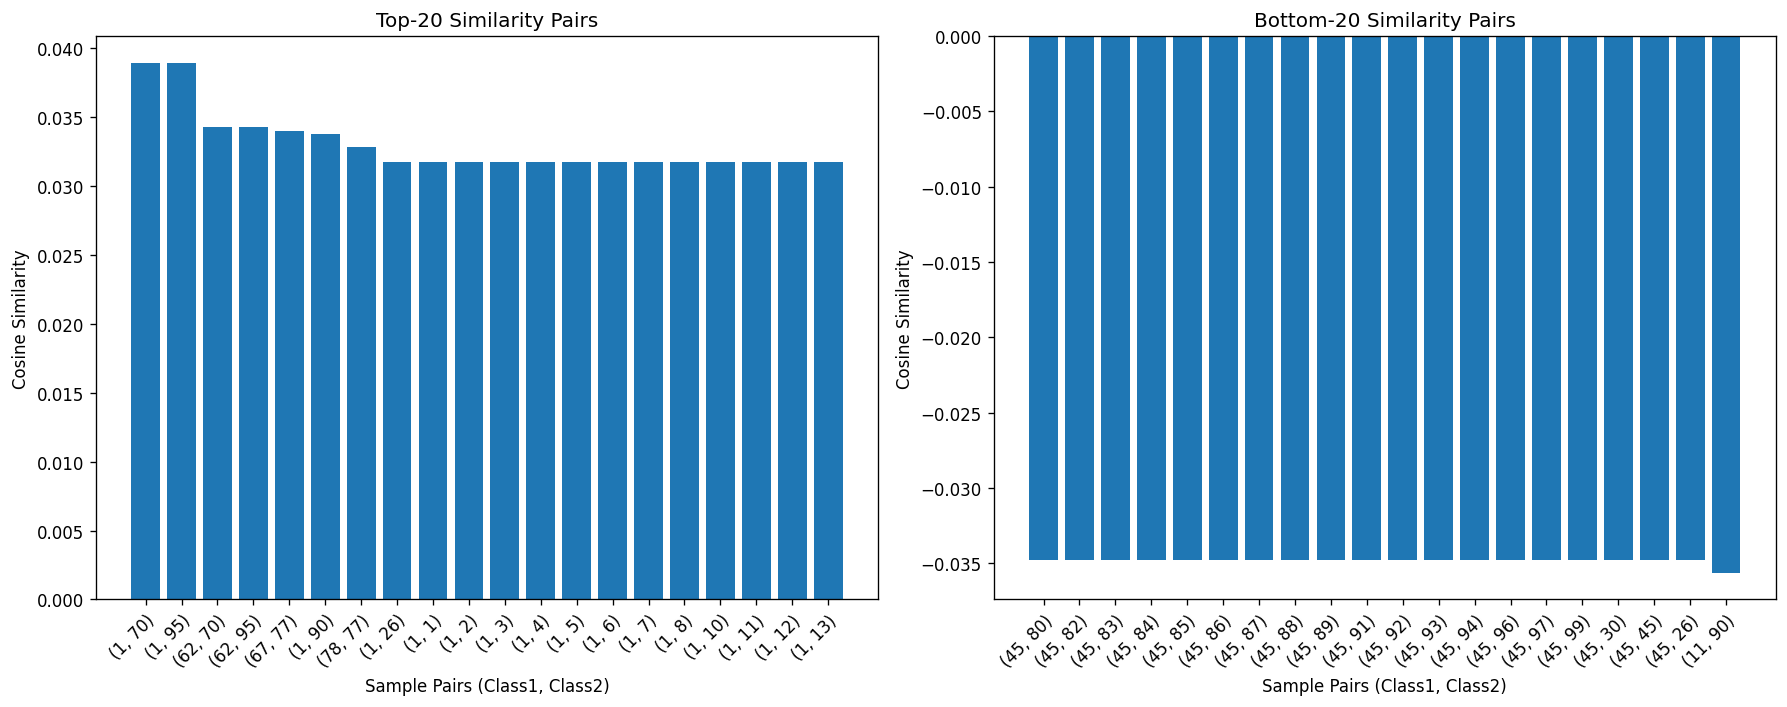

In [24]:
cross_category_similarity(donations_values_list2, donations_values_list3, top_n=20)

In [25]:
import torch  
import matplotlib.pyplot as plt  

def compute_channel_similarities(donations_values_list1, donations_values_list2):  
    """  
    计算两个类别之间的样本在每个channel上的平均相似度。  

    Parameters:  
        donations_values_list1 (list): 第一个类别的样本列表，每个样本为形状 (2048,) 的 PyTorch tensor。  
        donations_values_list2 (list): 第二个类别的样本列表，每个样本为形状 (2048,) 的 PyTorch tensor。  

    Returns:  
        list: 包含每个channel的平均相似度的列表。  
    """  
    num_samples1 = len(donations_values_list1)  
    num_samples2 = len(donations_values_list2)  
    num_channels = donations_values_list1[0].shape[0]  # 获取channel数量（假设为2048）  

    # 初始化每个channel的总和为0  
    channel_sums = torch.zeros(num_channels)  

    for i in range(num_samples1):  
        for j in range(num_samples2):  
            # 计算绝对差异  
            abs_diff = torch.abs(donations_values_list1[i] - donations_values_list2[j])  
            
            # 计算归一化因子（绝对差异的总和）  
            sum_diff = torch.sum(abs_diff)  
            
            # 避免除以零的情况  
            normalized_diff = abs_diff / (sum_diff + 1e-8)  
            
            # 将归一化后的差异累加到对应的channel  
            channel_sums += normalized_diff  

    # 计算每个channel的平均相似度  
    total_pairs = num_samples1 * num_samples2  # 样本对的总数  
    channel_means = channel_sums / total_pairs  

    return channel_means  


def calculate_ylim(channel_means, buffer=0.0):  
    """  
    计算y轴范围，固定在0到0.2之间。  
    """  
    ymin = 0.0  
    ymax = 0.2  
    return (ymin, ymax)  

def plot_channel_similarities(channel_means, num_channels=2048, ylim=None):  
    """  
    绘制每个channel的平均相似度的柱状图，纵坐标范围固定为0-0.2。  
    
    Parameters:  
        channel_means (list): 包含每个channel的平均相似度的列表。  
        num_channels (int): channel的数量。默认为2048。  
        ylim (tuple, optional): 指定y轴的范围（ymin, ymax）。如果未提供，函数会使用默认范围(0, 0.2)。  
        
    Returns:  
        tuple: y轴范围 (ymin, ymax)  
    """  
    plt.figure(figsize=(12, 6))  
    plt.bar(range(num_channels), channel_means, color='blue')  
    plt.title('Average Similarity Across Channels')  
    plt.ylabel('Normalized Similarity')  
    
    # 如果未提供ylim，使用默认的0-0.2范围  
    if ylim is None:  
        ylim = calculate_ylim(channel_means)  
    plt.ylim(ylim)  
    
    # 移除x轴标签和刻度  
    plt.xticks([])  
    plt.xlabel('')  
    
    plt.tight_layout()  
    plt.show() 



In [26]:
def cross_category_average_similarity(donations_values_list1, donations_values_list2):
    # 计算每个channel的平均相似度  
    channel_means = compute_channel_similarities(donations_values_list1, donations_values_list2)  
    # 绘制柱状图  
    plot_channel_similarities(channel_means)  

In [27]:
# cross_category_average_similarity(donations_values_list1, donations_values_list2)